# Testings for PlesioGeostroPy

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from scipy import special as specfun
import matplotlib.pyplot as plt

from pg_utils.pg_model import base, core

import os, perfplot
plt.style.use("default")

**Regularity tests** are now removed from this notebook.
For further regularity conditions and tests, see [Demo_Regularity.ipynb](Demo_Regularity.ipynb)

---
## Jacobi polynomial evaluation test

In [153]:
from scipy.special import eval_jacobi, roots_jacobi
from pg_utils.numerics.special import eval_jacobi_to_Nmax, eval_jacobi_nrange

### Precision test

In [154]:
n_range = np.arange(-2, 101)
alpha, beta = 1/2, -1/2
xi, wt = roots_jacobi(101, alpha, beta)
N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [155]:
Jacobi_val_scipy = eval_jacobi(N_mesh, alpha, beta, X_mesh)
Jacobi_val_recur = eval_jacobi_nrange(n_range[0], n_range[-1], alpha, beta, xi)

Compare the results

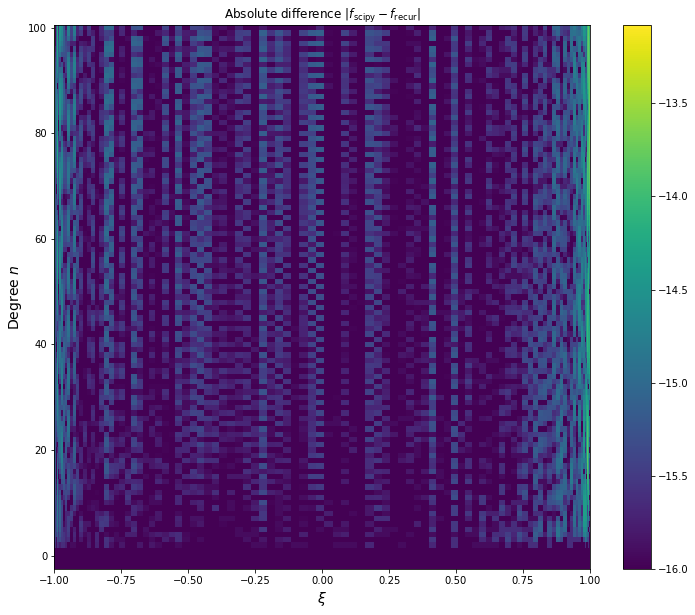

In [156]:
fig, ax = plt.subplots(figsize=(12, 10))

relative_err = np.abs(Jacobi_val_scipy - Jacobi_val_recur) + 1e-17
im = ax.pcolormesh(X_mesh, N_mesh, np.log10(relative_err), vmin=-16)
ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel("Degree $n$", fontsize=14)
ax.set_title(r"Absolute difference $|f_{\mathrm{scipy}} - f_{\mathrm{recur}}|$")
plt.colorbar(im)

plt.show()

$L_2$-error

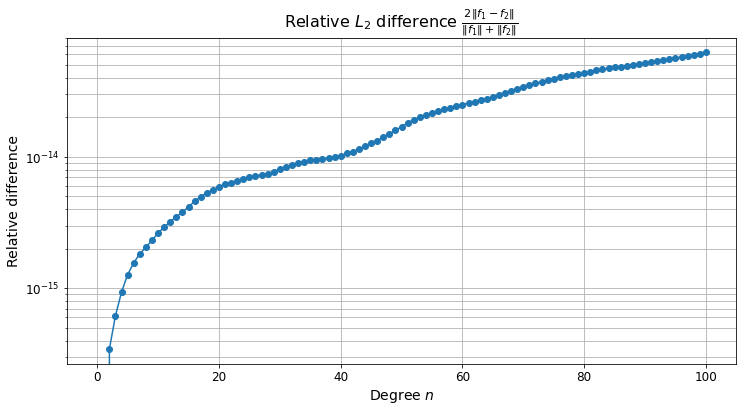

In [157]:
norm_Jacobi_scipy = np.sum(Jacobi_val_scipy**2*wt, axis=-1)
norm_Jacobi_recur = np.sum(Jacobi_val_recur**2*wt, axis=-1)
norm_diff = np.sum((Jacobi_val_scipy - Jacobi_val_recur)**2*wt, axis=-1)

fig, ax = plt.subplots(figsize=(12, 6))

relative_err = np.sqrt(norm_diff[n_range >= 0])/((np.sqrt(norm_Jacobi_recur[n_range >= 0]) + np.sqrt(norm_Jacobi_scipy[n_range >= 0]))/2)
ax.semilogy(n_range[n_range >= 0], relative_err, 'o-')
ax.set_xlabel("Degree $n$", fontsize=14)
ax.set_ylabel("Relative difference", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title(r"Relative $L_2$ difference $\frac{2\Vert f_1 - f_2 \Vert}{\Vert f_1\Vert + \Vert f_2\Vert}$", fontsize=16)
ax.grid(which="both")

plt.show()

It therefore seems that what is computed using recurrence relation and what is computed using the library function is different by at most $10^{-13}$, both in the absolute sense and in the relative sense.

### Efficiency test

Define functions for testing

In [158]:
npts_eval = 100

def params_setup(Nmax):
    n_range = np.arange(Nmax + 1)
    alpha, beta = 1/2, -1/2
    xi, _ = roots_jacobi(npts_eval, alpha, beta)
    N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')
    return n_range, xi, N_mesh, X_mesh, alpha, beta

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [159]:
benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi(N_mesh, alpha, beta, X_mesh),
        lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_nrange(n_range[0], n_range[-1], alpha, beta, xi)
        # lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_to_Nmax(n_range[-1], alpha, beta, xi)
    ],
    labels=["scipy", "recurrence"],
    n_range=[int(10**(N/5)) for N in range(0, 16)]
)

Output()

Compare the results

In [160]:
benchmarks

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ scipy                  ┃ recurrence             ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1    │ 2.3e-06                │ 9.5e-06                │
│ 1    │ 2.3e-06                │ 9.5e-06                │
│ 2    │ 4.1000000000000006e-06 │ 4.52e-05               │
│ 3    │ 6.5000000000000004e-06 │ 5.2300000000000004e-05 │
│ 6    │ 1.76e-05               │ 6.92e-05               │
│ 10   │ 4.1400000000000003e-05 │ 8.620000000000001e-05  │
│ 15   │ 8.54e-05               │ 0.00010850000000000001 │
│ 25   │ 0.00024170000000000002 │ 0.000155               │
│ 39   │ 0.0006174              │ 0.0002179              │
│ 63   │ 0.0015591000000000001  │ 0.0003283              │
│ 100  │ 0.0036338000000000004  │ 0.0004951              │
│ 158  │ 0.0084136              │ 0.0007508              │
│ 251  │ 0.019506100000000002   │ 0.0011803              │
│ 398  │ 0.0466897              │ 0.0018612000000000001  │
│ 630  │ 0.114155               │ 0.0029242              │
│ 1000 │ 0.28448090000000004    │ 0.004698               │
└──────┴────────────────────────┴────────────────────────┘

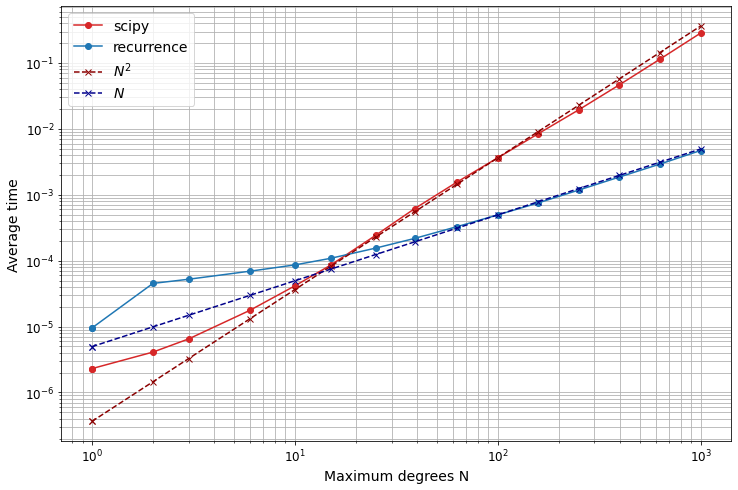

In [161]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

Scalings for two approaches
- Naively calling `scipy.special.eval_jacobi` on an array of degrees up to degree N gives a complexity of $O(N^2)$.
- Using recurrence relations to generate values for the same array of degrees gives a complexity of $O(N)$.

Naturally, `scipy` functions are better optimized and this particular function is computed with C functions.
A factor of $\sim 10$ exists between the two implementations at low degrees, and the current crossing point of the two complexity curves is located at $N\approx 18$.

Profiler

In [35]:
%lprun -f eval_jacobi_to_Nmax [eval_jacobi_nrange(0, 100, alpha, beta, xi) for i in range(500)]

Timer unit: 1e-07 s

Total time: 0.339706 s
File: C:\Users\gentle\Documents\Projects\PG-Assim\pg_utils\numerics\special.py
Function: eval_jacobi_to_Nmax at line 38

Line #      Hits         Time  Per Hit   % Time  Line Contents
    38                                           def eval_jacobi_to_Nmax(Nmax: int, alpha: float, beta: float, z: np.ndarray):
    39                                               """Evaluate Jacobi polynomials up to a degree
    40                                               
    41                                               This functions generates values for Jacobi polynomials from degree 0
    42                                               up to a specified degree, using recurrence relations.
    43                                               
    44                                               :param int Nmax: maximum degree, required to be >= 1
    45                                               :param float alpha: alpha index for Jacobi polynom

---
## Inner product matrix

In [101]:
from pg_utils.numerics import matrices
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import expand_conjugate as xpd_cfg
from eigen_solve import routine_matrix_calculation

### Single inner product efficiency

In [113]:
import json
from pg_utils.pg_model import params
from sympy import oo, Integer, Rational

matrix_expr_file = "./out/cases/Malkus/Conjugate_recipe/Matrix_expr.json"
matrix_name = 'M'
element_name = ("Psi", "Psi")

PHYS_PARAMS = {
    xpd.m: Integer(3), 
    params.Le: Rational(1, 10000), 
    params.Lu: oo
}

with open(matrix_expr_file, 'r') as fread:
    matrix_obj = json.load(fread)
M_expr = xpd.SystemMatrix.deserialize(matrix_obj[matrix_name])
ip_element = M_expr[element_name].subs(PHYS_PARAMS)
ip_quad = matrices.InnerQuad_GaussJacobi(ip_element, automatic=True, quadN=None)

In [114]:
Ntrunc = 5
nrange = np.arange(Ntrunc + 1)

ip_eval = ip_quad.gramian(nrange, nrange, backend="scipy", output="numpy", outer=False, verbose=True)

Integrating with alpha=3/2, beta=3, N=6


Benchmarks between integration approach and outer product approach

In [117]:
def params_setup(Nmax):
    return matrix_expr_file, np.arange(Nmax + 1), xpd_cfg.recipe

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda fname, nrange, recipe: ip_quad.gramian(nrange, nrange, backend="scipy", output="numpy", outer=False, verbose=False),
        lambda fname, nrange, recipe: ip_quad.gramian(nrange, nrange, backend="scipy", output="numpy", outer=True, verbose=False),
    ],
    labels=["integrand", "outer product"],
    n_range=[int(N) for N in np.logspace(1, 2, num=10)]
)

Output()

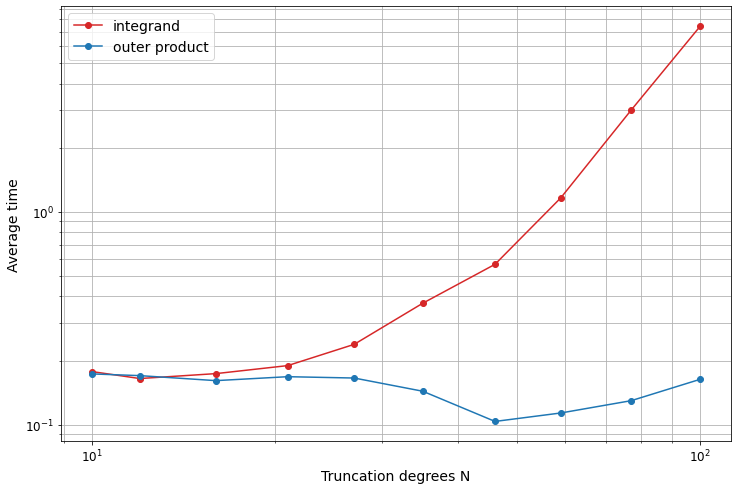

In [118]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Truncation degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

### Integrating entire matrices

In [100]:
matrix_expr_file = "./out/cases/Malkus/Conjugate_recipe/Matrix_expr.json"
Ntrunc = 5

%time M_val, K_val = routine_matrix_calculation(read_from=matrix_expr_file, Ntrunc=Ntrunc, xpd_recipe=xpd_cfg.recipe, save_to=None, outer=False, verbose=0)

CPU times: total: 2.2 s
Wall time: 2.79 s


In [90]:
def params_setup(Nmax):
    return matrix_expr_file, Nmax, xpd_cfg.recipe

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda fname, Ntrunc, recipe: routine_matrix_calculation(read_from=fname, Ntrunc=Ntrunc, xpd_recipe=recipe, save_to=None, outer=False, verbose=0),
        lambda fname, Ntrunc, recipe: routine_matrix_calculation(read_from=fname, Ntrunc=Ntrunc, xpd_recipe=recipe, save_to=None, outer=True, verbose=0),
        # lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_to_Nmax(n_range[-1], alpha, beta, xi)
    ],
    labels=["integrand", "outer product"],
    n_range=[N for N in range(5, 51, 5)]
)

Output()

Compare the results

In [91]:
benchmarks

┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ n  ┃ integrand          ┃ outer product      ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 5  │ 3.1876548000000002 │ 3.2573915          │
│ 10 │ 2.9989798000000003 │ 2.4869838          │
│ 15 │ 1.9450728000000002 │ 1.9926299          │
│ 20 │ 2.2636971000000004 │ 1.9487894000000001 │
│ 25 │ 2.9452701          │ 2.0608336          │
│ 30 │ 4.6481684          │ 1.9484819000000002 │
│ 35 │ 6.154250500000001  │ 1.9708147          │
│ 40 │ 8.7625466          │ 1.9948519000000002 │
│ 45 │ 12.577491400000001 │ 2.1037445000000004 │
│ 50 │ 17.998745800000002 │ 2.1088283000000003 │
└────┴────────────────────┴────────────────────┘

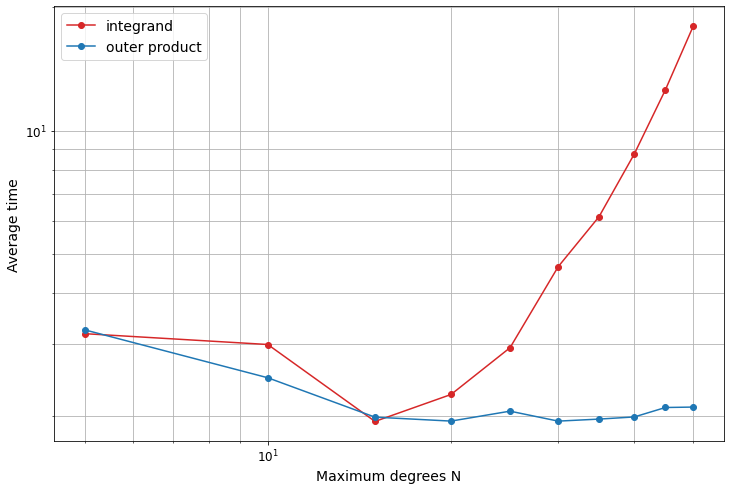

In [92]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

### Precision

In [95]:
import h5py
matrix_value_compare = "./out/cases/Malkus/Conjugate_recipe/Matrix_eval.h5"
with h5py.File(matrix_value_compare, 'r') as fread:
    M_cmp = fread['M'][()]
    K_cmp = fread['K'][()]

print("Mass matrices ...")
if np.allclose(M_val, M_cmp):
    print("  match up to machine precion.")
else:
    print("  differ by max. %.2e." % np.abs(M_val - M_cmp).max())
print("Stiffness matrices ...")
if np.allclose(K_val, K_cmp):
    print("  match up to machine precion.")
else:
    print("  differ by max. %.2e." % np.abs(K_val - K_cmp).max())

Mass matrices ...
  match up to machine precion.
Stiffness matrices ...
  match up to machine precion.


---
## Multi-precision calculation

### Multi-precision datatypes

According to the benchmarks below, converting numpy array to gmpy2 floats is more efficient by a factor of 1.4 to over 2.

In [2]:
import gmpy2 as gp
import mpmath as mp

mp.mp.prec = 112
print(mp.mp)

Mpmath settings:
  mp.prec = 112               [default: 53]
  mp.dps = 33                 [default: 15]
  mp.trap_complex = False     [default: False]


In [220]:
rng = np.random.default_rng()

np2gp = np.vectorize(lambda x: gp.mpfr(x, 112), otypes=(object,))
np2mp = np.vectorize(lambda x: mp.mpf(x), otypes=(object,))

def params_setup(Nmax):
    return rng.normal(size=(Nmax, Nmax)), rng.normal(size=(Nmax, Nmax))

def np_2_gmpy2(A, B):
    A_out = np.array([[gp.mpfr(A[i_r, i_c], 112) for i_c in range(A.shape[1])] for i_r in range(A.shape[0])], dtype=object)
    B_out = np.array([[gp.mpfr(B[i_r, i_c], 112) for i_c in range(B.shape[1])] for i_r in range(B.shape[0])], dtype=object)
    return A_out, B_out

def np_2_mpmath(A, B):
    A_out = np.array([[mp.mpf(A[i_r, i_c]) for i_c in range(A.shape[1])] for i_r in range(A.shape[0])], dtype=object)
    B_out = np.array([[mp.mpf(B[i_r, i_c]) for i_c in range(B.shape[1])] for i_r in range(B.shape[0])], dtype=object)
    return A_out, B_out

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        # np_2_gmpy2, 
        # np_2_mpmath
        lambda a, b: (np2gp(a), np2gp(b)),
        lambda a, b: (np2mp(a), np2mp(b)),
    ],
    labels=["numpy->gmpy2", "numpy->mpmath"],
    n_range=[int(N) for N in np.logspace(1, 3, num=10)],
    equality_check=None
)

Output()

In [221]:
benchmarks

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ numpy->gmpy2          ┃ numpy->mpmath         ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 10   │ 0.0003976             │ 0.0005813000000000001 │
│ 16   │ 0.0010373000000000001 │ 0.0015006000000000002 │
│ 27   │ 0.0029124000000000003 │ 0.0042646             │
│ 46   │ 0.008475              │ 0.012605300000000002  │
│ 77   │ 0.0239256             │ 0.0366445             │
│ 129  │ 0.071956              │ 0.1073013             │
│ 215  │ 0.1984718             │ 0.30458270000000004   │
│ 359  │ 0.5630929             │ 1.4834821             │
│ 599  │ 1.5352113             │ 3.882076              │
│ 1000 │ 4.3680868             │ 9.567089600000001     │
└──────┴───────────────────────┴───────────────────────┘

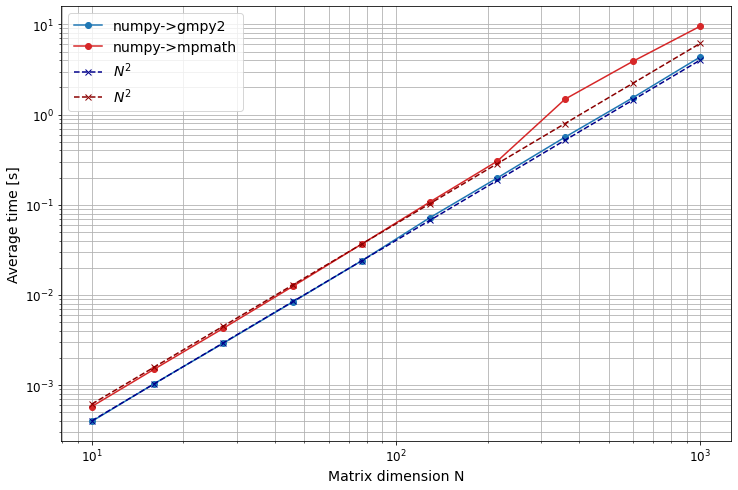

In [222]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:blue", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6])**2)*benchmarks.n_range**2, 'x--', color="darkblue", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6]**2)*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")

ax.set_xlabel("Matrix dimension N", fontsize=14)
ax.set_ylabel("Average time [s]", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

### Multi-precision linear algebra

The speed of linear algebra is tested with the matrix-matrix multiplication (matmul).

Result shows that `gmpy2` float can be 5~6 times more efficient than `mpmath` float.
However, since neither are as optimized as double-precision float in numpy, the matmul operation follows an uninteresting $N^3$ even at moderate dimension, and can be 4 orders of magnitudes slower than numpy.

In [182]:
rng = np.random.default_rng()

def params_setup(Nmax):
    A, B = rng.normal(size=(Nmax, Nmax)), rng.normal(size=(Nmax, Nmax))
    A_gp = np.array([[gp.mpfr(A[i_r, i_c], 112) for i_c in range(A.shape[1])] for i_r in range(A.shape[0])], dtype=object)
    B_gp = np.array([[gp.mpfr(B[i_r, i_c], 112) for i_c in range(B.shape[1])] for i_r in range(B.shape[0])], dtype=object)
    A_mp = np.array([[mp.mpf(A[i_r, i_c]) for i_c in range(A.shape[1])] for i_r in range(A.shape[0])], dtype=object)
    B_mp = np.array([[mp.mpf(B[i_r, i_c]) for i_c in range(B.shape[1])] for i_r in range(B.shape[0])], dtype=object)
    return A, B, A_gp, B_gp, A_mp, B_mp

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda a1, b1, a2, b2, a3, b3: a1 @ b1,
        lambda a1, b1, a2, b2, a3, b3: a2 @ b2, 
        lambda a1, b1, a2, b2, a3, b3: a3 @ b3
    ],
    labels=["numpy", "gmpy2", "mpmath"],
    n_range=[int(N) for N in np.logspace(0.5, 2, num=10)],
    equality_check=None
)

Output()

In [183]:
benchmarks

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n   ┃ numpy                  ┃ gmpy2                  ┃ mpmath                ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 3   │ 2.0000000000000003e-06 │ 1.36e-05               │ 6.25e-05              │
│ 4   │ 2.0000000000000003e-06 │ 3.1100000000000004e-05 │ 0.0001533             │
│ 6   │ 2.1000000000000002e-06 │ 0.00010520000000000001 │ 0.0005394             │
│ 10  │ 2.3e-06                │ 0.0004968              │ 0.0026033000000000002 │
│ 14  │ 2.8000000000000003e-06 │ 0.0013982              │ 0.007312600000000001  │
│ 21  │ 5.8e-06                │ 0.004752500000000001   │ 0.025191400000000003  │
│ 31  │ 1.3100000000000002e-05 │ 0.0154309              │ 0.0832619             │
│ 46  │ 1.34e-05               │ 0.0511988              │ 0.2868778             │
│ 68  │ 1.3700000000000001e-05 │ 0.16873370000000001    │ 0.9533467000000001    │
│ 100 │ 2.9e-05                │ 0.5375257              │ 3.1618958000000004    │
└─────┴────────────────────────┴────────────────────────┴───────────────────────┘

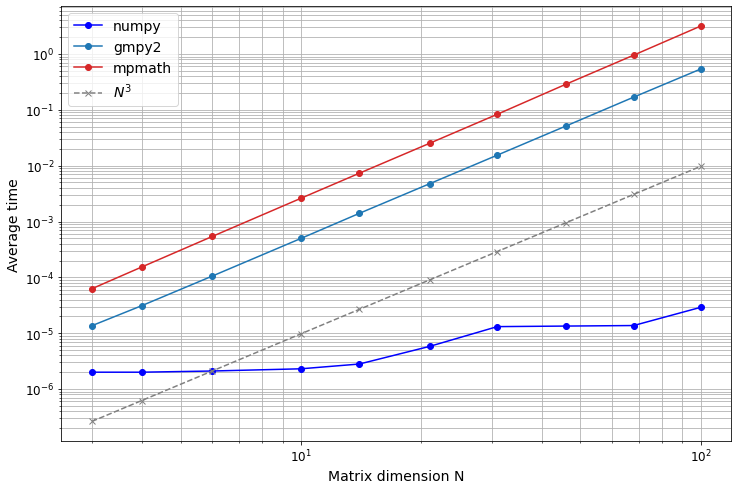

In [192]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["blue", "tab:blue", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -8]/(benchmarks.n_range[-8])**3)*benchmarks.n_range**3, 'x--', color="gray", label=r"$N^3$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/(benchmarks.n_range[-6])**3)*benchmarks.n_range**3, 'x--', color="darkblue", label=r"$N^2$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[2, -6]/benchmarks.n_range[-6]**3)*benchmarks.n_range**3, 'x--', color="darkred", label=r"$N^2$")

ax.set_xlabel("Matrix dimension N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

### Jacobi nodes

In [68]:
from sympy.integrals.quadrature import gauss_jacobi
from pg_utils.numerics.special import roots_jacobi_mp
import sympy
import pandas as pd

Benchmark

The multi-precision Gauss-Jacobi quadrature weights and nodes calculation via `sympy.integrals.quadrature.gauss_jacobi` is used as a benchmark.

This method is quite slow, using around 25s for the following $N$, $\alpha$, $\beta$ configuration. The double-prec version `scipy.special.roots_jacobi` is very fast.

Note that there seems to be some caching in the Jacobi evaluation for `sympy`. The second run is often a lot faster.

In [60]:
%%time
xi_sp_mp, wt_sp_mp = gauss_jacobi(100, sympy.Rational(-1,2), sympy.S.Zero, n_digits=34)
xi_np_dp, wt_np_dp = specfun.roots_jacobi(100, -0.5, 0.)

CPU times: total: 41.4 s
Wall time: 44 s


The sympy routine to calculate the nodes is quite slow, and I don't want to waste 20-30s on calculating one set of nodes for N=100. For reduced system, we are looking at 5 nontrivial matrix blocks, so 100-150s will be spent on calculating the nodes and weights alone. For the full system, this would exceed 700s: more than 10 minutes spent on calculating the nodes and weights alone. This is unbearable.

Instead, since the double precision algorithm is very fast (and it is fast because the roots are obtained by solving the eigenvalue problem of a banded matrix, whose elements are related to the coefficients from the recurrence relation), I want to see if I can run a Newton-Rhapson refinement using the `scipy.specials.roots_jacobi` solutions as a starting point.

In [63]:
%%time

mp.mp.prec = 115
alpha_mp, beta_mp = mp.mpf("-0.5"), mp.mpf("0.0")

roots_result = roots_jacobi_mp(100, alpha_mp, beta_mp, n_dps=34, extra_dps=8, max_iter=10)
xi_mp_newton = roots_result.xi
wt_mp = roots_result.wt

CPU times: total: 109 ms
Wall time: 229 ms


In [64]:
roots_result

Jacobi polynomial root-finding result:
Root-finding successful.
Convergence to 34 digits after 3 iters

Quite successful really... and it takes only 0.2s.

In [69]:
df_nodes = pd.DataFrame(data={
    "scipy double": xi_np_dp, 
    "sympy dps=34": xi_sp_mp, 
    "scipy + Newton refine": [gp.mpfr(str(xi), 112) for xi in xi_mp_newton]
})
df_nodes.iloc[:5, :].transpose().style.format("{:.32f}")

,0,1,2,3,4
scipy double,-0.99971229548776008311250507176737,-0.99848441235832563478425072389655,-0.99627662205050782073811888039927,-0.99309060159914885890231062148814,-0.98892941939967404785249982523965
sympy dps=34,-0.99971229548775997116606474817077,-0.99848441235832564272967596906802,-0.99627662205050781363500407860635,-0.99309060159914881138231096452343,-0.98892941939967396311380357456058
scipy + Newton refine,-0.99971229548775997116606474817077,-0.99848441235832564272967596906802,-0.99627662205050781363500407860635,-0.99309060159914881138231096452343,-0.98892941939967396311380357456058


In [66]:
df_weights = pd.DataFrame(data={
    "scipy double": wt_np_dp, 
    "sympy dps=34": wt_sp_mp,
    "scipy + Newton refine": [gp.mpfr(str(wt), 112) for wt in wt_mp]
})

In [67]:
df_weights.iloc[:5, :].transpose().style.format("{:.32f}")

,0,1,2,3,4
scipy double,0.00052209963862769536661195823868,0.00121522418362476187191079102234,0.00190907696669464273936389631103,0.00260255023378054171565021412960,0.00329540246467605914271192801834
sympy dps=34,0.00052209963864736080483863273355,0.00121522418362357224038327179809,0.00190907696669735644718387511154,0.00260255023377868656888681827135,0.00329540246467667222387581809540
scipy + Newton refine,0.00052209963864736080483863273355,0.00121522418362357224038327179809,0.00190907696669735644718387511154,0.00260255023377868656888681827135,0.00329540246467667222387581809540


And the accuracy is definitely enough. Since the original error is already at the order of magnitude of $10^{-14}$, and Newton-Rhapson has a quadratic convergence rate, a very limited number of refinements is necessary to push it to very high precision. Because of this property, `scipy.special.roots_jacobi` also applies one iteration of Newton-Rhapson refinement after solving the eigenvalue problem.

### Jacobi batch evaluation

---
## Velocity and vorticity basis

In [42]:
from scipy.special import binom, eval_jacobi, roots_jacobi

def basis_psi(m, n, s):
    xi = 2*s**2 - 1
    return s**m*(1 - s**2)**(3/2)*eval_jacobi(n, 3/2, m, xi)

def basis_u_s(m, n, s):
    xi = 2*s**2 - 1
    return m*s**(m-1)*(1-s**2)*eval_jacobi(n, 3/2, m, xi)

def basis_u_p(m, n, s):
    xi = 2*s**2 - 1
    return s**(m-1)*(3*s**2 - m*(1-s**2))*eval_jacobi(n, 3/2, m, xi) - s**(m + 1)*(1 - s**2)*(n + m + 5/2)*eval_jacobi(n-1, 5/2, m+1, xi)

def basis_zeta(m, n, s):
    xi = 2*s**2 - 1
    return (2*(n + 1)*(2*n + 2*m + 3) + m)*s**m*eval_jacobi(n, 3/2, m, xi)

Calculate the basis functions

In [49]:
m = 3
n_array = np.array([1, 3, 5, 10])
curve_colors = ["tab:blue", "tab:green", "tab:orange", "tab:red"]
xi_array, _ = roots_jacobi(200, 3/2, m)
s_array = np.r_[0., np.sqrt((1 + xi_array)/2), 1.]

N_mesh, S_mesh = np.meshgrid(n_array, s_array, indexing='ij')

basis_val_psi = basis_psi(m, N_mesh, S_mesh)
basis_val_u_s = basis_u_s(m, N_mesh, S_mesh)
basis_val_u_p = basis_u_p(m, N_mesh, S_mesh)
basis_val_zeta = basis_zeta(m, N_mesh, S_mesh)

Plot the basis functions

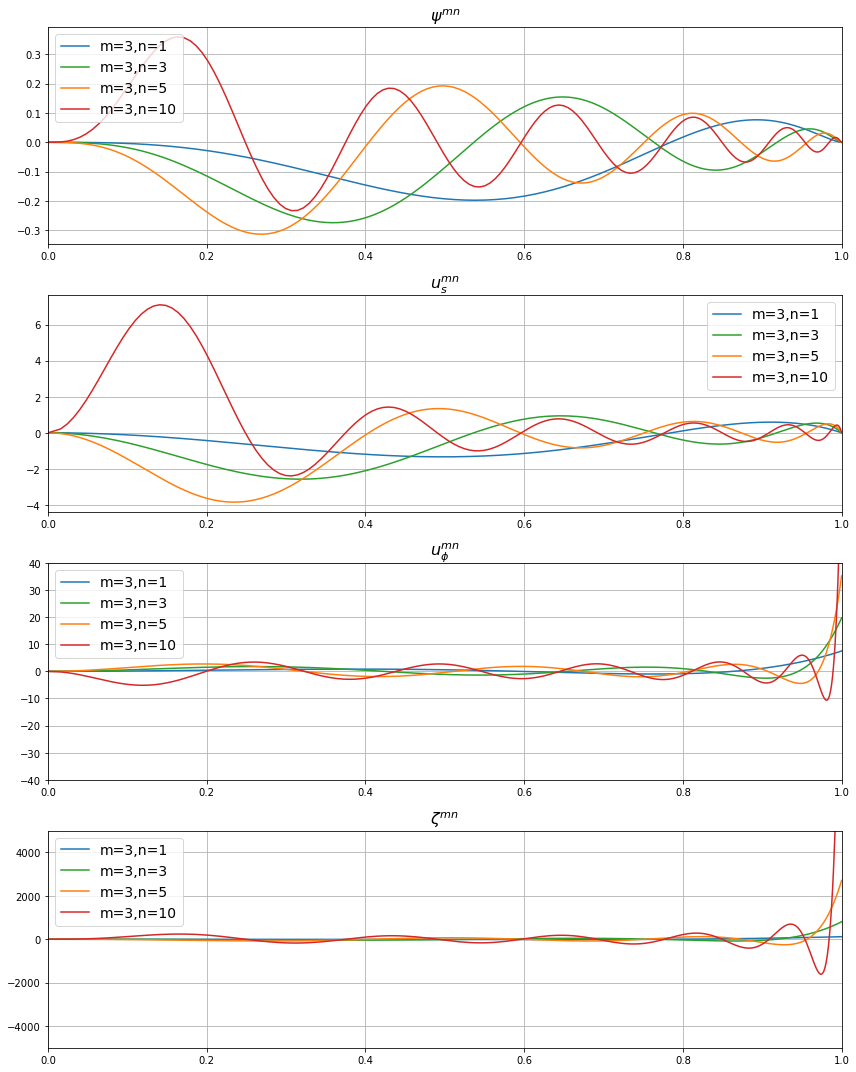

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 15))

ax = axes[0]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_psi[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$\psi^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)

ax = axes[1]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_u_s[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$u_s^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)

ax = axes[2]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_u_p[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$u_\phi^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([-40, +40])

ax = axes[3]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_zeta[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$\zeta^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([-5000, +5000])

plt.tight_layout()
plt.savefig("./out/imgs/basis_velocity_vorticity.pdf", format="pdf", bbox_inches="tight")
plt.show()